In [1]:
import logging
import sys
logging.disable(sys.maxsize)

In [2]:
from datetime import datetime

from pathlib import Path
import warnings
import os
import re
import pickle
import pandas as pd

import jax

os.chdir('/home/bszh/MILE')

from src.config.core import Config
from src.config.sampler import Sampler
from src.config.data import DatasetType
import src.dataset as ds
import src.training.utils as train_utils
import src.inference.utils as inf_utils
import src.visualization as viz
from src.config.data import Task
from src.inference.evaluation import evaluate_de, evaluate_bde


In [3]:
os.environ['SANDBOX_EXPERIMENT_DIR'] = '/home/bszh/MILE/results/bikesharing/bike_sgle1_20250610-192029'
try:
    DIR = Path(os.environ['SANDBOX_EXPERIMENT_DIR'])
except KeyError as e:
    raise KeyError('Please set the "SANDBOX_EXPERIMENT_DIR" variable') from e

tree_dir = DIR / 'tree'

<h1><center>Log Summary</center></h1>

In [4]:
def get_total_time(logs: str):
    log_lines = [line for line in logs.split('\n') if line]
    # Extract Timestamp
    if len(log_lines) < 2:
        return 0 
    start = re.findall(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', log_lines[0])[0]
    end = re.findall(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', log_lines[-1])[0]
    return (datetime.fromisoformat(end) - datetime.fromisoformat(start)).total_seconds()

with open(DIR / 'training.log', 'r') as f:
    logs = f.read()

warm_incomplete = False
bde_incomplete = False

warmstart_match = re.findall(r'time.warmstart took (\d+.\d+) seconds', logs)
bde_match = re.findall(r'time.sampling took (\d+.\d+) seconds', logs)
if warmstart_match:
    warmstart_time = float(warmstart_match[0])
    if bde_match:
        bde_time = float(bde_match[0])
    else:
        bde_time = get_total_time(logs) - warmstart_time
        bde_incomplete = True
else:
    warm_incomplete = True
    bde_incomplete = True
    warmstart_time = get_total_time(logs)
    bde_time = 0

total_time = round(warmstart_time + bde_time, 2)
print("-" * 50)
print(f'Warmstart time: {round(warmstart_time / 60, 2)} min{" (incomplete)" if warm_incomplete else ""}')
print(f'BDE time: {round(bde_time / 60, 2)} min{" (incomplete)" if bde_incomplete else ""}')
print(f'Total time: {round(total_time / 60, 2)} min{" (incomplete)" if warm_incomplete or bde_incomplete else ""}')
print("-" * 50)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    config = Config.from_yaml(DIR / 'config.yaml')
# print(f"> Loaded Configuration:\n{config}")
metrics = {
    'total_time': total_time,
    'warmstart_time': warmstart_time,
    'bde_time': bde_time
}


--------------------------------------------------
Warmstart time: 1.45 min (incomplete)
BDE time: 0.0 min (incomplete)
Total time: 1.45 min (incomplete)
--------------------------------------------------


## Warmstart Results

In [ ]:
warmstart_dir = DIR / 'warmstart'
files = [warmstart_dir / f for f in os.listdir(warmstart_dir) if f.endswith('.npz')]
params_warmstart = train_utils.load_params_batch(files, tree_path=tree_dir)
if len(files) == 1:
    params_warmstart = jax.tree.map(lambda x: x[None, ...], params_warmstart)
print(f'Number of NaNs:\n{inf_utils.count_nan(params_warmstart)}')
viz.plot_warmstart_results(warmstart_dir=warmstart_dir)
# viz.plot_param_hist(params_warmstart, hist_=10000)

<center><h1>Sampling Warmup</center></h1>

In [ ]:
if config.training.sampler.name == Sampler.MCLMC:
    with open(DIR / 'warmup_params.txt', 'r') as f:
        lines = f.readlines()
        step_size = jax.numpy.array([float(x) for x in lines[0].strip().split(',')])
        L = jax.numpy.array([float(x) for x in lines[1].strip().split(',')])

    print('Tuned MCLMC Parameters after warmup:')
    print(f'Step Size: {jax.numpy.mean(step_size):.4f} ± {jax.numpy.std(step_size):.4f}')
    print(f'L: {jax.numpy.mean(L):.4f} ± {jax.numpy.std(L):.4f}')
    metrics['step_size'] = jax.numpy.mean(step_size)
    metrics['L'] = jax.numpy.mean(L)
    metrics['step_size_std'] = jax.numpy.std(step_size)
    metrics['L_std'] = jax.numpy.std(L)

In [ ]:
# Limit memory usage
if config.training.sampler.keep_warmup:
    samples_warmup = train_utils.load_samples_from_dir(DIR / 'sampling_warmup', tree_path=tree_dir)
    n_samples = inf_utils.count_samples(samples_warmup)
    n_chains = inf_utils.count_chains(samples_warmup)
    print(f'Loaded {n_chains} chains with {n_samples} warmup samples each')
    print(f'Number of NaNs:\n{inf_utils.count_nan(samples_warmup)}')
    _ = viz.plot_effective_sample_size(samples_warmup)
    viz.plot_param_movement(samples_warmup, random_n=5)
    # viz.plot_param_hist(samples_warmup, hist_limit=10000)
else:
    print('> No warmup samples has been saved.')

<center><h1>Sampling</center></h1>

Loaded 4 chains with 399 samples each


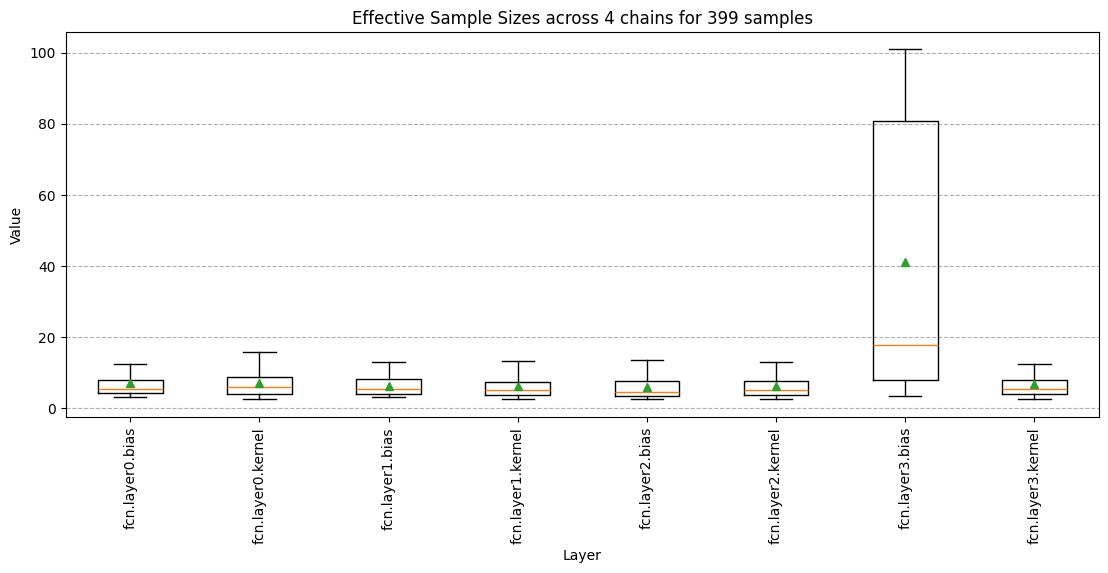

In [5]:
samples = train_utils.load_samples_from_dir(DIR / 'samples', tree_path=tree_dir)
n_samples = inf_utils.count_samples(samples)
n_chains = inf_utils.count_chains(samples)
print(f'Loaded {n_chains} chains with {n_samples} samples each')
mean_ess = viz.plot_effective_sample_size(samples)

### Variance Analysis

ValueError: Number of samples must be divisible by n_splits

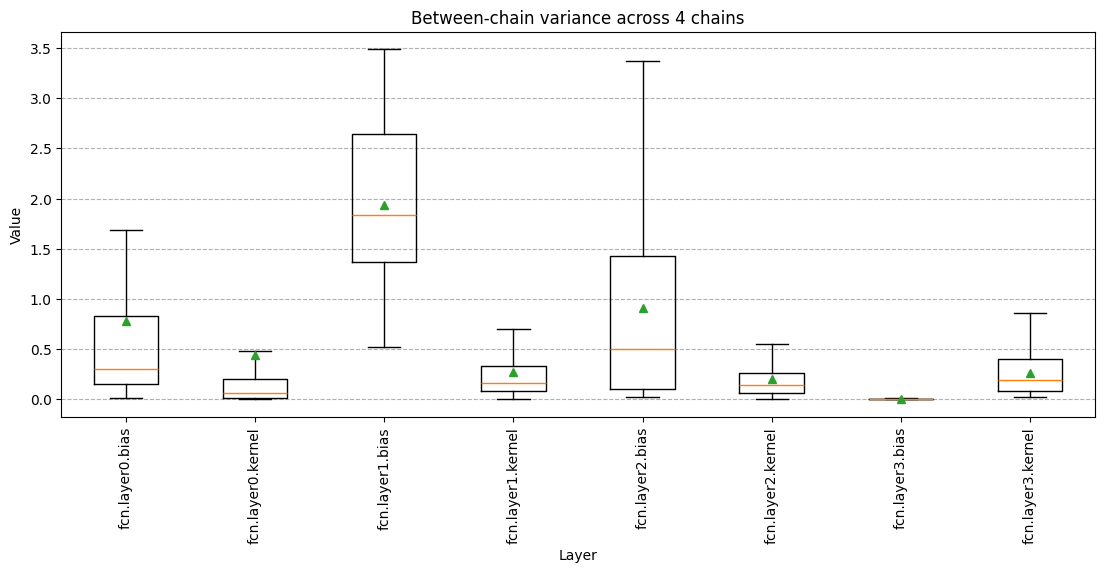

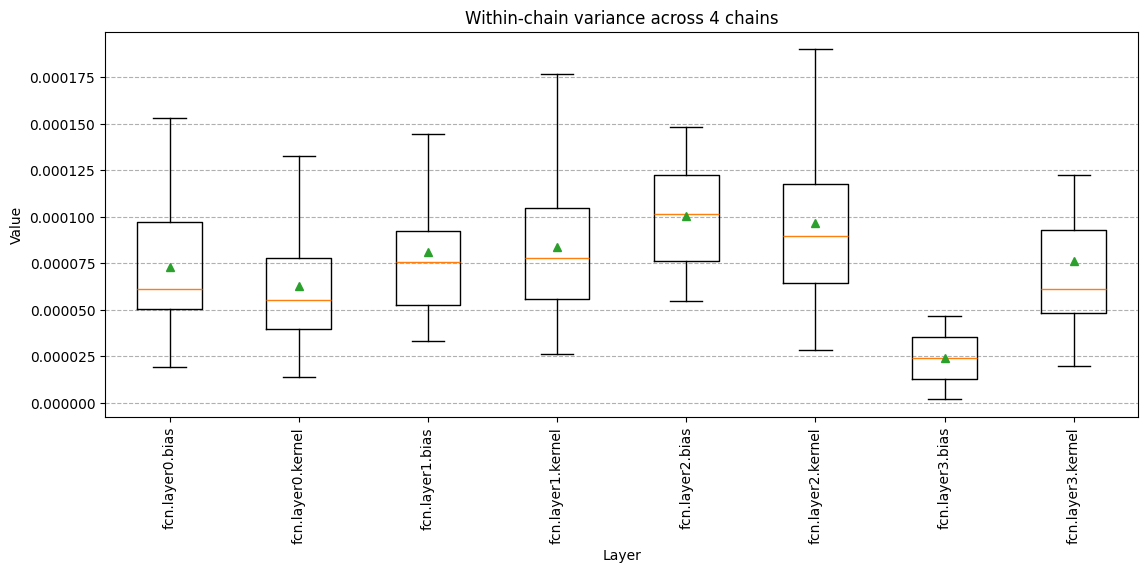

In [6]:
mean_bcv, mean_wcv = viz.plot_variances(samples)
mean_crhat = viz.plot_split_chain_r_hat(samples, n_splits=4)
# viz.plot_param_hist(samples, hist_limit=10000)

### Visualizing Sampling

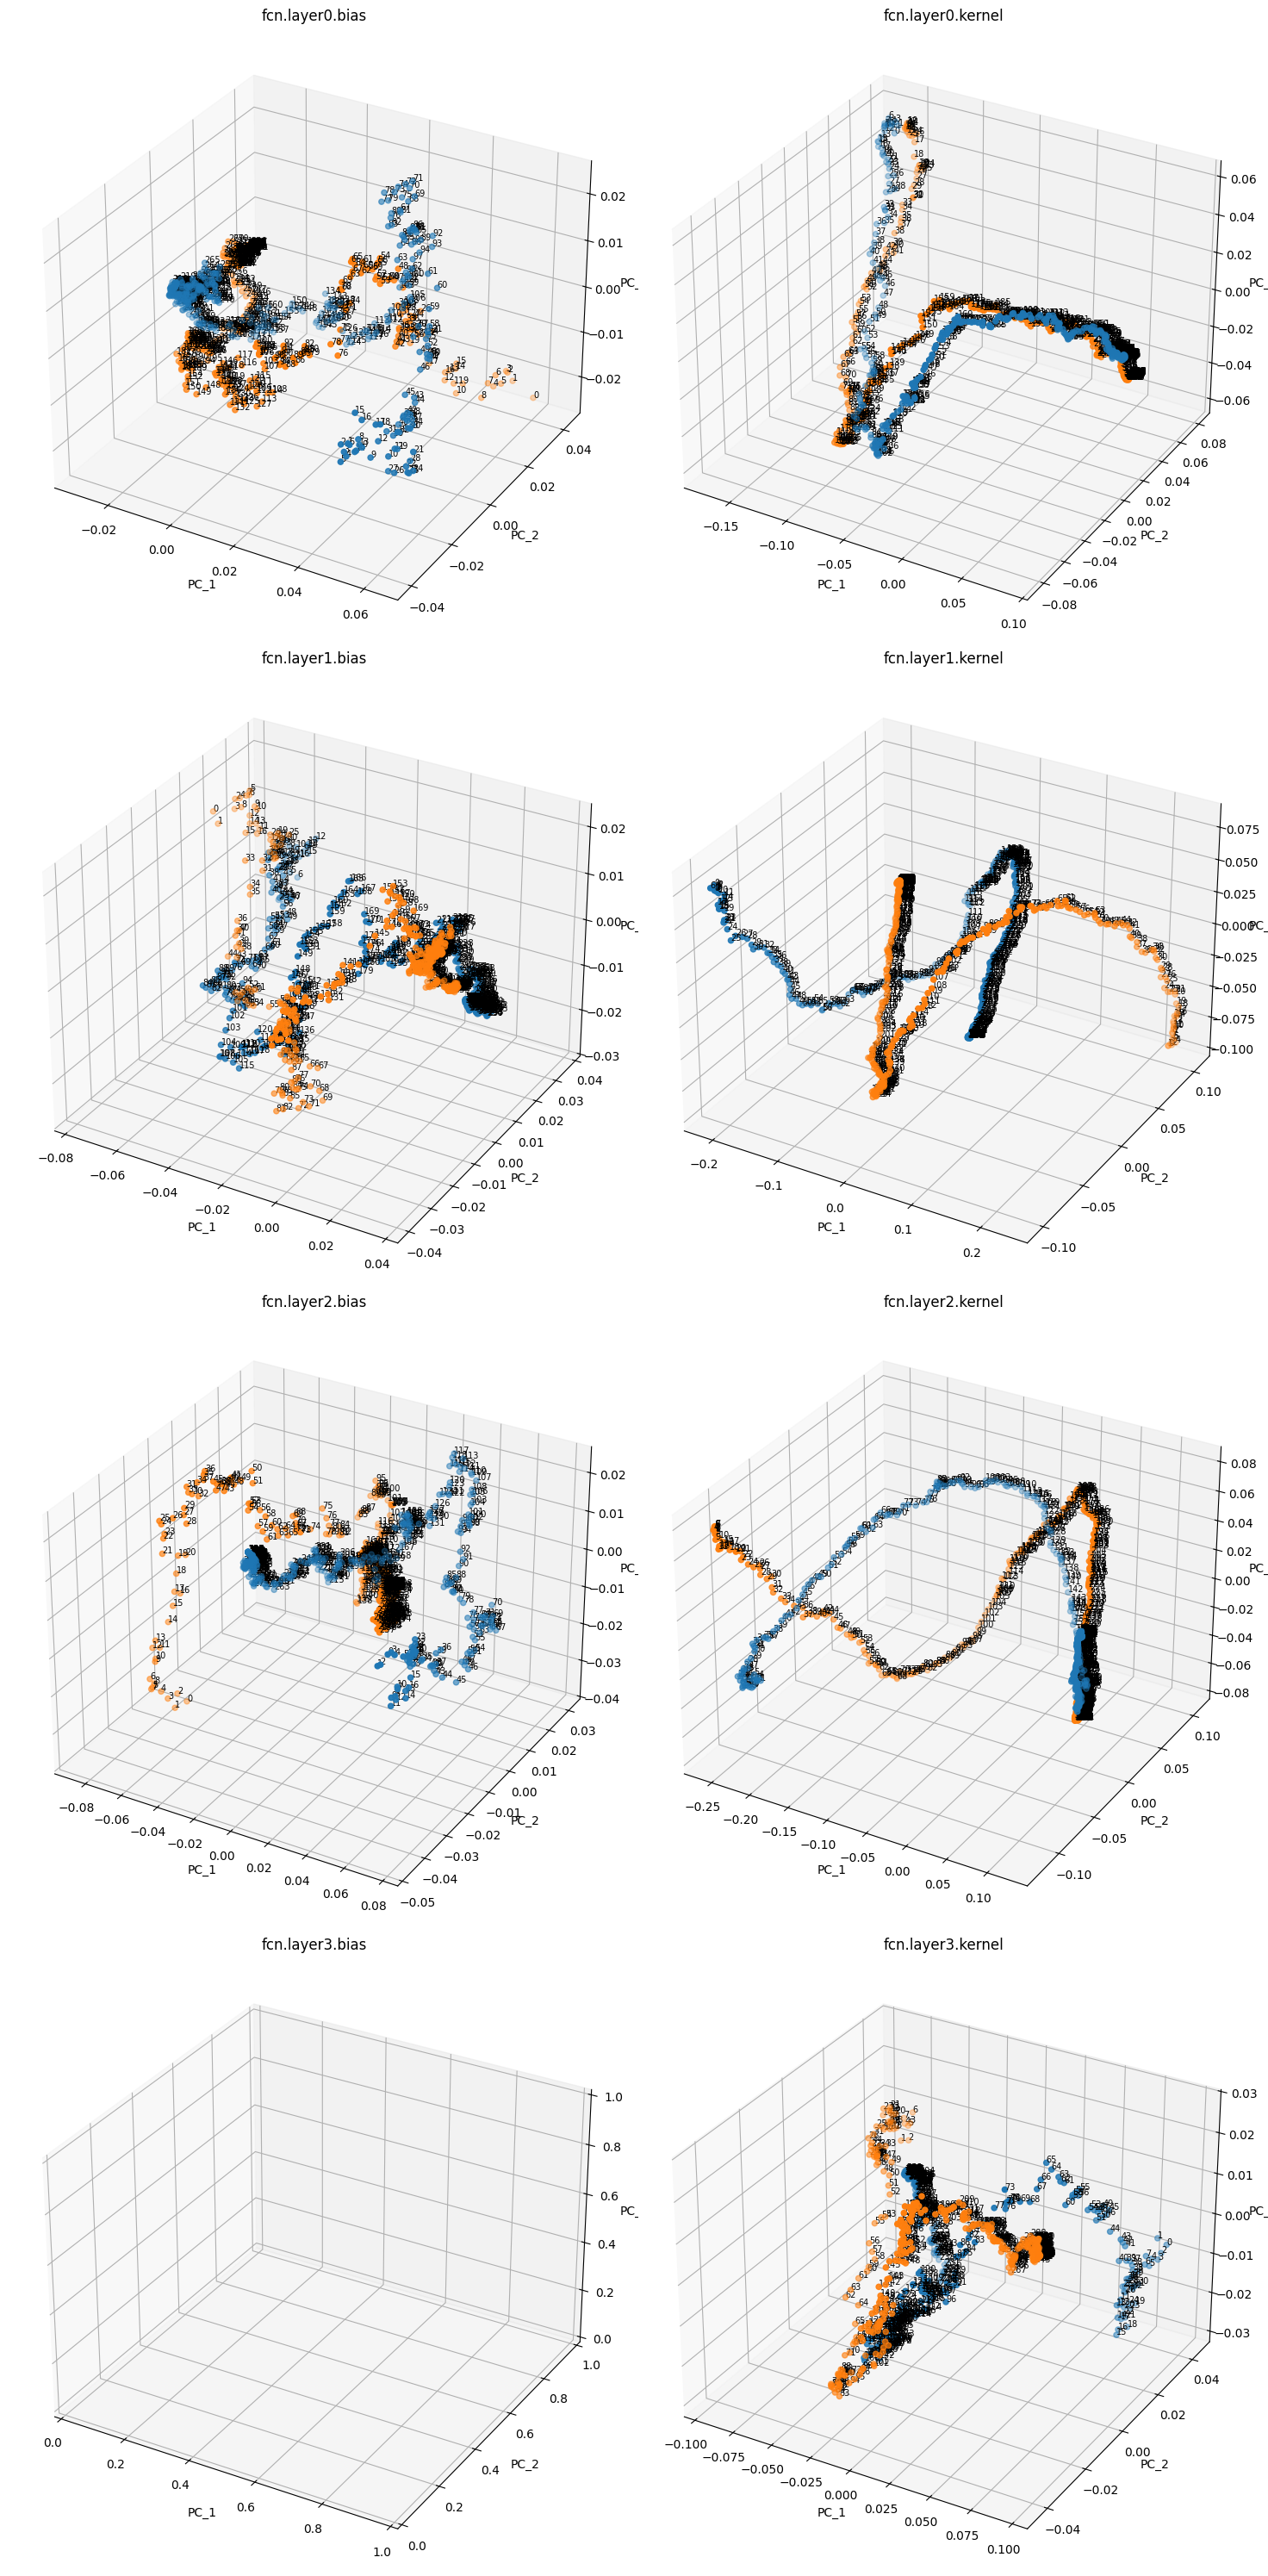

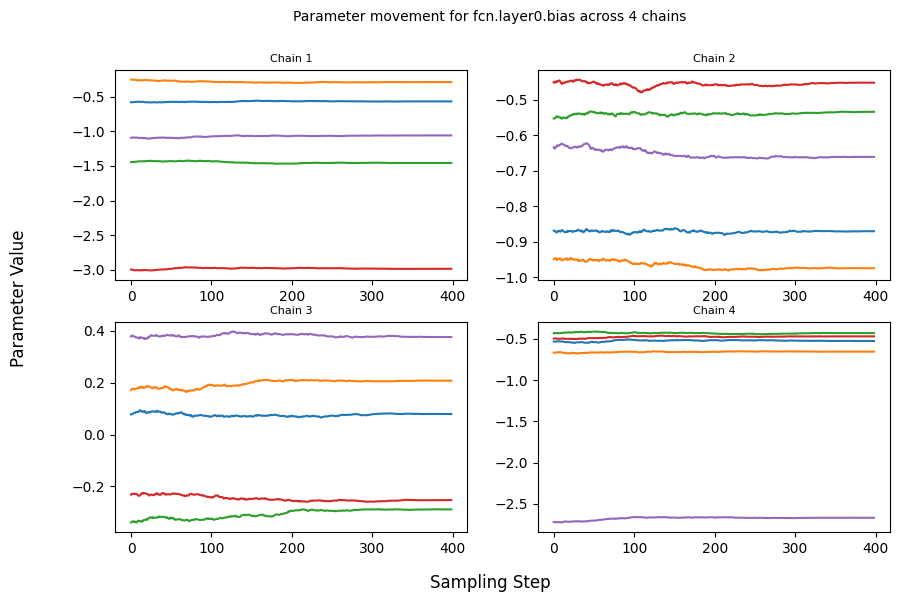

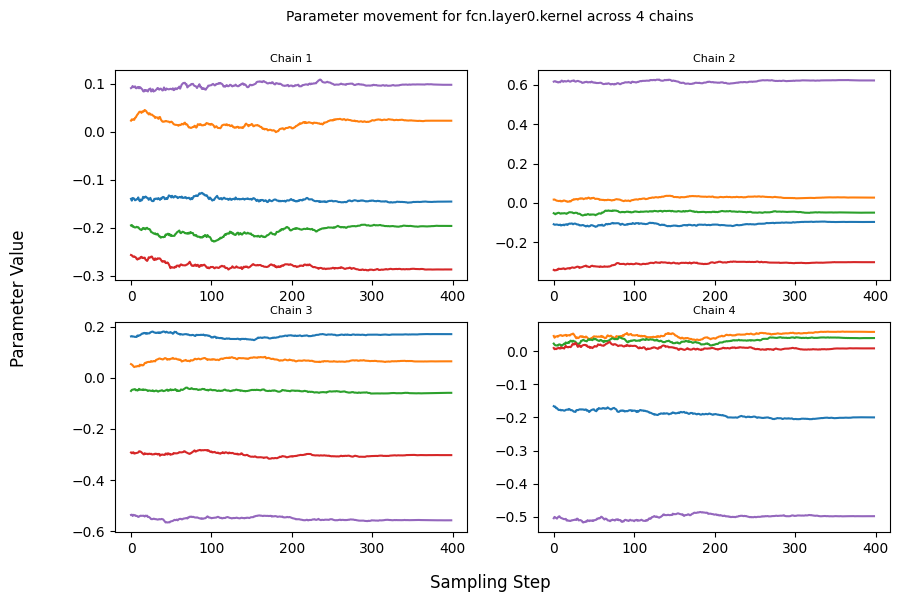

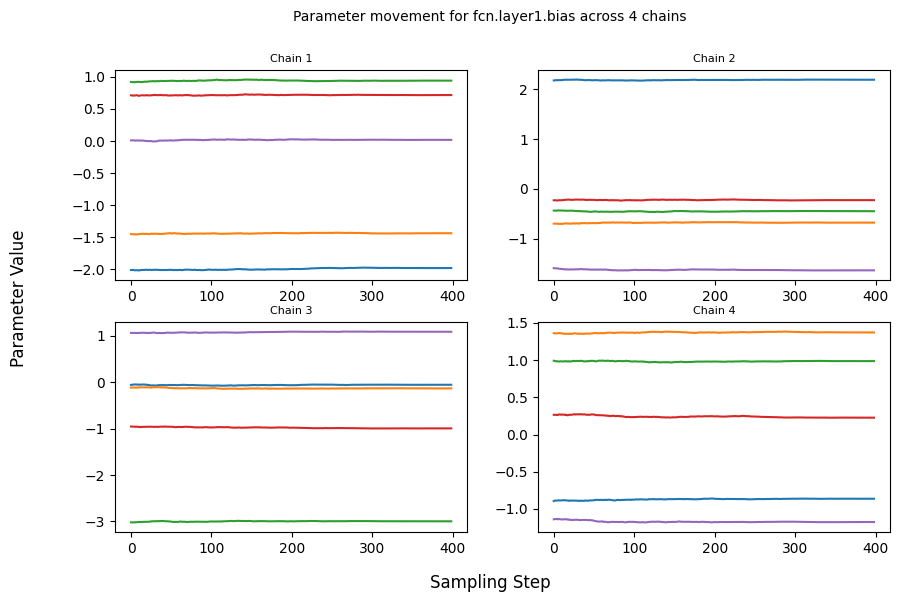

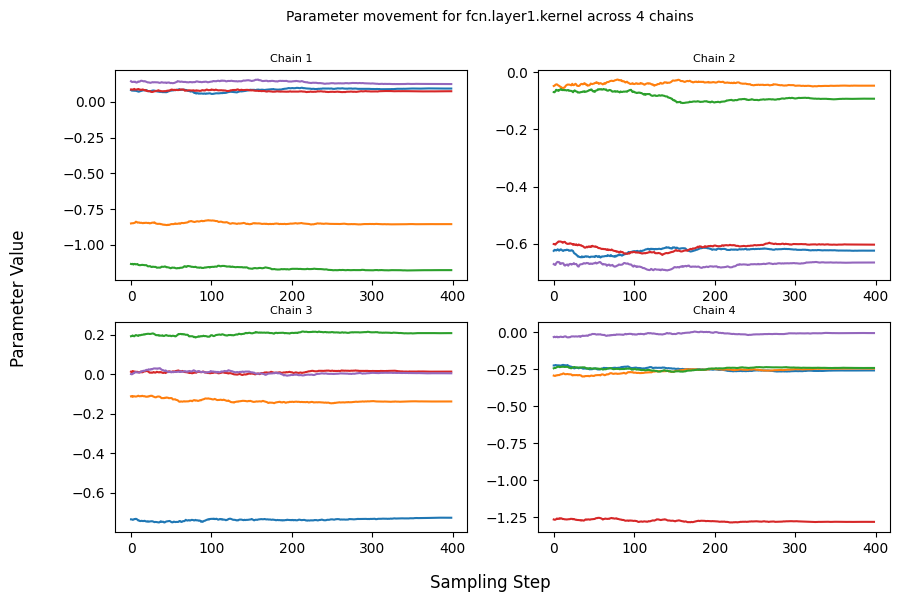

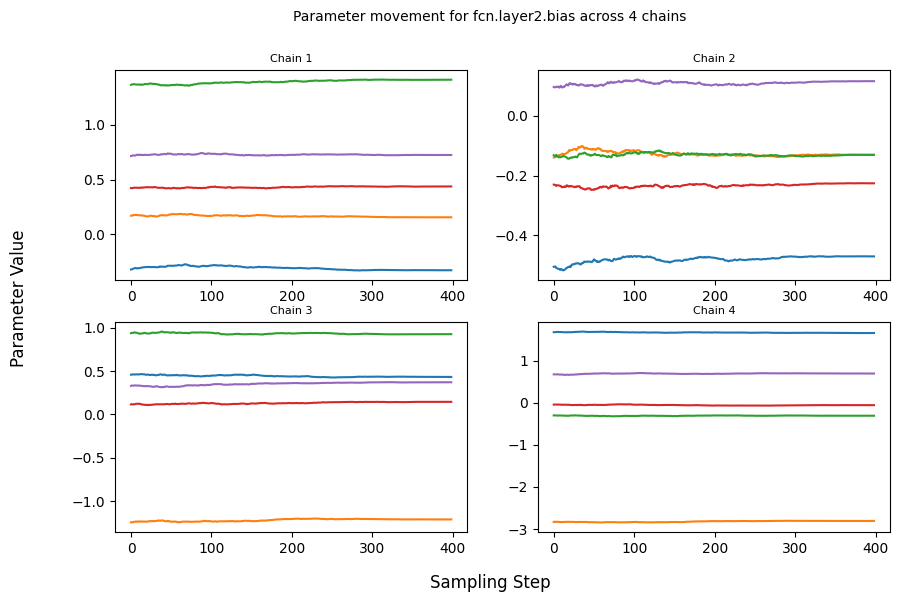

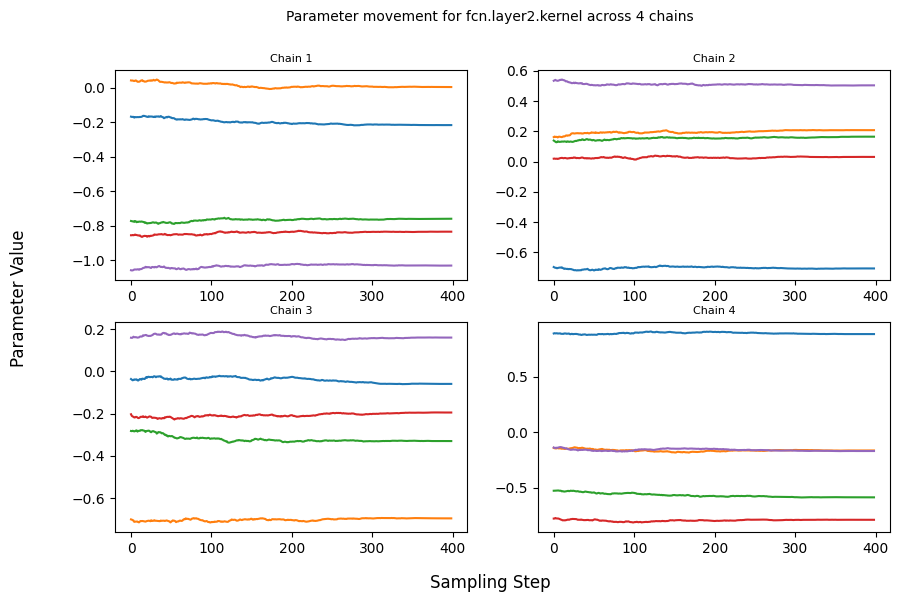

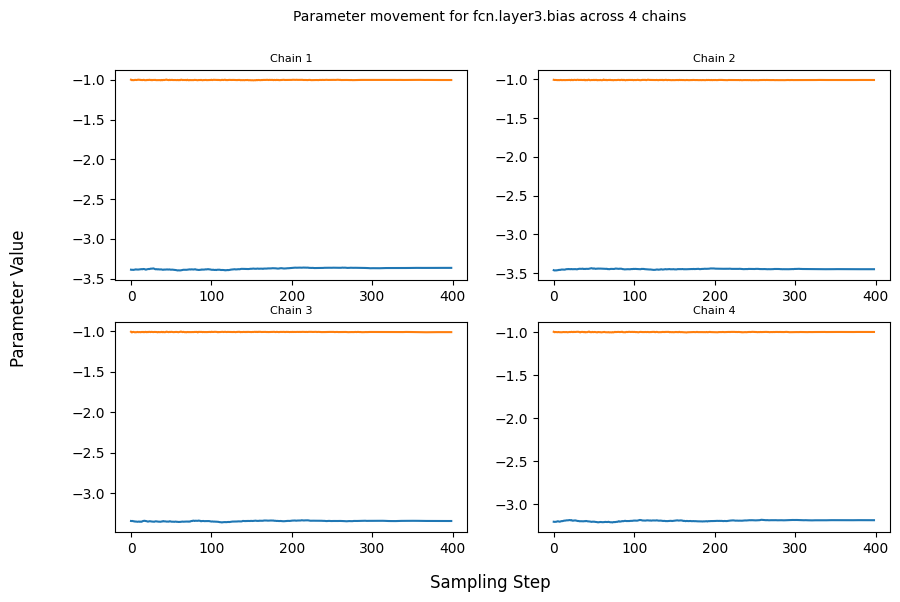

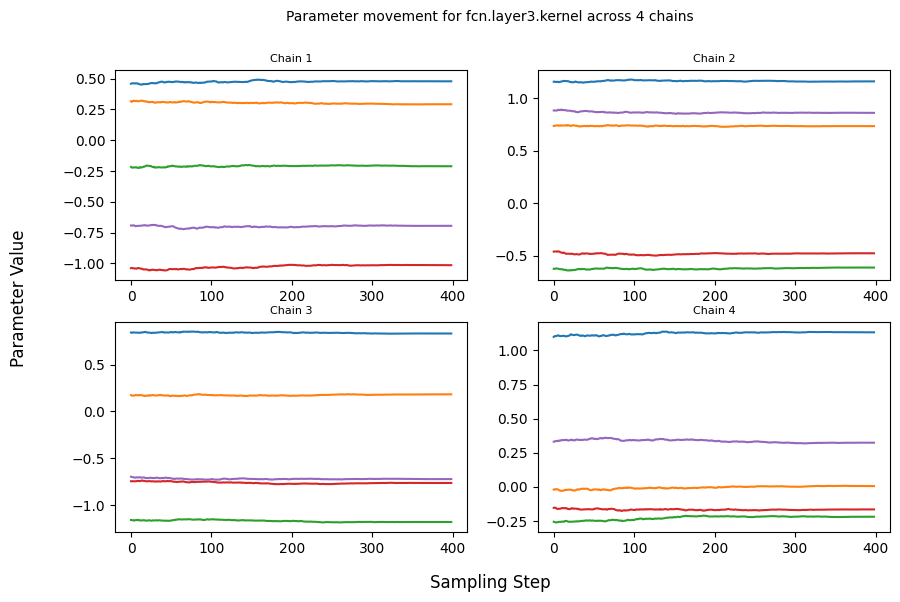

In [7]:
viz.plot_pca(samples, '3d', max_chains=2, max_samples=None, annotate=True)
viz.plot_param_movement(samples, random_n=5)

In [8]:
# Combine the mean diagnostics into a dataframe and save it
rows = list(mean_ess.keys())
columns = ['ess', 'bcv', 'wcv', 'crhat']
df = pd.DataFrame(index=rows, columns=columns)
df['ess'] = mean_ess.values()
df['bcv'] = mean_bcv.values()
df['wcv'] = mean_wcv.values()
df['crhat'] = mean_crhat.values()
df.to_csv(DIR / 'diagnostics.csv')

NameError: name 'mean_crhat' is not defined

<center><h1>DE vs BDE Performance</center></h1>

In [9]:
# Extra arguments needed in forward pass of the flax model
kwargs = {}

# Setup Loader
if config.data.data_type == DatasetType.TABULAR:
    loader = ds.TabularLoader(
        config.data,
        rng=config.jax_rng,
        target_len=config.data.target_len
    )
elif config.data.data_type == DatasetType.TEXT:
    from src.dataset.utils import CustomBPETokenizer
    tokenizer = CustomBPETokenizer(
        config.model.context_len, max_vocab_size=config.model.vocab_size
    )
    loader = ds.TextLoader(
        config=config.data,
        rng=config.jax_rng,
        tokenizer=tokenizer,
        context_len=config.model.context_len,
        omit_freq=100,
    )
    kwargs = {'train': False, 'pad_id': tokenizer.padding_token_id}
elif config.data.data_type == DatasetType.IMAGE:
    loader = ds.ImageLoader(
        config.data,
        rng=config.jax_rng,
    )
else:
    raise NotImplementedError(f'DatasetType {config.data.data_type} not supported yet.')

random_input = next(loader.iter('train', 1))['feature']

print(f'> Loader:\n{loader}')
module = config.get_flax_model()

print('> Parameter Overview:\n')
print(module.tabulate(config.jax_rng, x=random_input, **kwargs))

with open(DIR / 'samples/info.pkl', 'rb') as f:
    info = pickle.load(f)

accept_rate = info.get("acceptance_rate", None)
integration_steps = info.get("num_integration_steps", None)
if accept_rate is not None:
    print("Average acceptance rate: ", accept_rate.mean())
    metrics['acceptance_rate'] = accept_rate.mean()
if integration_steps is not None:
    print("Average ingeration steps: ", integration_steps.mean())
    metrics['integration_steps'] = integration_steps.mean()

> Loader:
TabularLoader:
 | Data: bikesharing
 | Task: regr
 | Features: 12
 | Target Length: 1
 | Train: 12165
 | Valid: 1738
 | Test: 3476
> Parameter Overview:


                                  FCN Summary                                   
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path       ┃ module         ┃ inputs         ┃ outputs       ┃ params        ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│            │ FCN            │ x:             │ float32[1,2]  │               │
│            │                │ float32[1,12]  │               │               │
├────────────┼────────────────┼────────────────┼───────────────┼───────────────┤
│ fcn        │ FullyConnected │ float32[1,12]  │ float32[1,2]  │               │
├────────────┼────────────────┼────────────────┼───────────────┼───────────────┤
│ fcn/layer0 │ Dense          │ float32[1,12]  │ float32[1,16] │ bias:         │
│            │           

In [10]:
features = loader.test_x # (B x F)
labels = loader.test_y # (B x T)
print("Test Set: Feature and Label have shapes: ", features.shape, labels.shape)

Test Set: Feature and Label have shapes:  (3476, 12) (3476,)


In [11]:
logits, metrics = evaluate_de(
    params=params_warmstart,
    module=module,
    features=features,
    labels=labels,
    task=config.data.task,
    batch_size=config.training.warmstart.batch_size,
    verbose=False,
    metrics_dict=metrics,
    n_samples=config.training.sampler.n_samples // config.training.sampler.n_thinning,
    rng_key=config.jax_rng,
    nominal_coverages=[0.5, 0.75, 0.9, 0.95],
    **kwargs
)

NameError: name 'params_warmstart' is not defined

In [12]:
mem_cap = 4 * 1024 ** 3 # 4 GB
mem_usage = (
    inf_utils.get_mem_size(samples) / n_chains
    + inf_utils.get_mem_size(features)
    + inf_utils.get_mem_size(labels)
)
overhead_unit = mem_usage * 10 # estimatation

batch_size = max(1, (mem_cap - overhead_unit) // mem_usage)
if batch_size > labels.shape[0]:
    batch_size = None
print(f'> Batch size for evaluation: {batch_size}\n')

> Batch size for evaluation: 2982.0



In [13]:
logits, metrics = evaluate_bde(
    params=samples,
    module=module,
    features=features,
    labels=labels,
    task=config.data.task,
    batch_size=batch_size,
    verbose=False,
    metrics_dict=metrics,
    nominal_coverages=[0.5, 0.75, 0.9, 0.95],
    **kwargs
)

Bayesian Deep Ensemble Performance | LPPD: 0.525, RMSE: 0.2428
__________________________________________________
Chain 0 | LPPD: 0.432, RMSE: 0.2568
Chain 1 | LPPD: 0.407, RMSE: 0.2605
Chain 2 | LPPD: 0.338, RMSE: 0.2659
Chain 3 | LPPD: 0.432, RMSE: 0.2618
__________________________________________________
Calibration Error: 0.0724
Coverage for 0.5: 0.5970
Coverage for 0.75: 0.8444
Coverage for 0.9: 0.9465
Coverage for 0.95: 0.9718


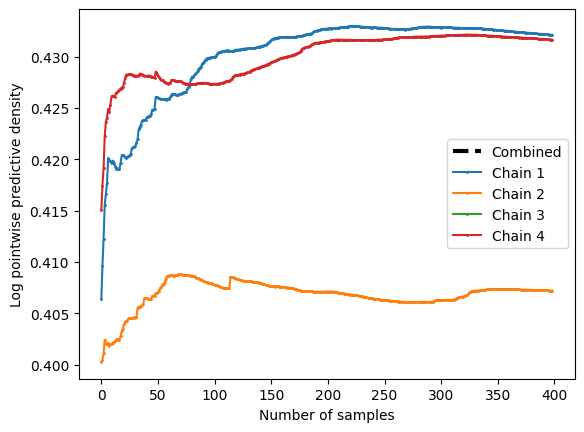

In [14]:
# LPPD over the samples
viz.plot_lppd(logits, labels, config.data.task)

In [ ]:
# save metrics
with open(DIR / 'metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)